In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt   #jupyter要matplotlib.pyplot
import numpy as np
import pandas as pd
from pandas import DataFrame
device = 'cuda:0' if torch.cuda.is_available() else "cpu"
device

'cpu'

In [2]:
filepath = "train.csv"
train_data = pd.read_csv(filepath)
test_data = pd.read_csv("test.csv")

In [3]:
'''将train.csv and test.csv 中的数据转化为np.array，按照原格式111*735一行一行的存入数组中'''
def loaddata(data, rows, lines):#将每一行的各列的数据放入train_data_row中
    data_rows=[]
    for row in range(0,rows):
        data_row=[]
        for line in range(0,lines):
            data_row.append(data[str(line)][row]) #将每一行的各列的数据放入train_data_row中
        data_rows.append(data_row)
    return np.array(data_rows)

In [4]:
def normalizationdata(data):  #归一化
    range = np.max(data) - np.min(data)
    return (data - np.min(data)) / range

In [5]:
'''将训练数据和测试数据的每一行都装入train_data_rows'''
train_data_rows = loaddata(train_data, 111, 735)
#print(train_data_rows[0])
test_data_rows = loaddata(test_data, 111, 56)
type(test_data_rows)

numpy.ndarray

In [6]:
'''将数据归一化处理'''
train_data_rows_nor = normalizationdata(train_data_rows)
test_data_rows_nor = normalizationdata(test_data_rows)
#test_data_rows_nor[0]

In [7]:
'''pytorch搭建一个mlp模型'''
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(679,128),
            nn.ReLU(),
            nn.Linear(128,32),
            nn.ReLU(),
            nn.Linear(32,56)
        )
    #forward和init函数要对齐，否则报错NotImplementedError
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
            

In [8]:
'''获取训练数据的输入和要和输出进行对比的标签'''
training_data = torch.from_numpy(train_data_rows_nor)
print(training_data.shape)

training_data_feature = training_data[:,[range(679)]]
#取training_data每行中的前679个训练数据,刚好能剩下56个做输出预测
training_data_feature = training_data_feature.squeeze()
#去除值为1的维度

training_data_pred = training_data[:,[range(679,735)]]
training_data_pred = training_data_pred.squeeze()

print(training_data_feature.shape)#输入的特征
print(training_data_pred.shape)#输出要进行比较的标签

torch.Size([111, 735])
torch.Size([111, 679])
torch.Size([111, 56])


In [9]:
print(training_data_feature)

tensor([[0.1397, 0.1534, 0.2143,  ..., 0.4453, 0.3245, 0.2695],
        [0.1204, 0.1416, 0.1567,  ..., 0.2710, 0.1359, 0.1152],
        [0.0588, 0.1500, 0.2545,  ..., 0.3463, 0.2060, 0.1893],
        ...,
        [0.1085, 0.1555, 0.2695,  ..., 0.3992, 0.0660, 0.1490],
        [0.1213, 0.1103, 0.1310,  ..., 0.2618, 0.1540, 0.1137],
        [0.0869, 0.1029, 0.1701,  ..., 0.2369, 0.1159, 0.1221]],
       dtype=torch.float64)


In [10]:
'''定义模型以及损失函数和优化方法'''
model = NeuralNetwork().to(device)
loss_MSE = nn.MSELoss()#定义损失函数为MSE
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [11]:
'''训练函数'''
def train(X_datas, y_datas, model, loss_mse, optimizer, epochs):
    size = X_datas.shape[0]
    model.train()

    losses = []
    iterations = []

    for epoch in range(epochs):
        for line in range(size):  #实验表明不一列一列直接整体梯度下降效果不太好
            X = X_datas[line]
            y = y_datas[line]
            X, y = X.to(device), y.to(device)

            pred = model(X)#预测值
            loss = loss_mse(pred, y)#损失计算

            optimizer.zero_grad()#后向传播
            loss.backward()
            optimizer.step()

            loss = loss.item()
        if epoch%100 == 0:
            print("the loss of epoch "+ str(epoch) + " is: " + str(loss))
            losses.append(loss)
            iterations.append(epoch)
    prediction = model(X_datas.to(device))

    plt.title("loss of epochs per 100")
    plt.xlabel("loss per 100")
    plt.ylabel("loss")
    plt.plot(iterations,losses)
    plt.show()

    return prediction.to('cpu')


    
    

the loss of epoch 0 is: 0.03465867415070534
the loss of epoch 100 is: 0.005851260386407375
the loss of epoch 200 is: 0.0010502486256882548
the loss of epoch 300 is: 0.0008871391182765365
the loss of epoch 400 is: 0.0009892506059259176


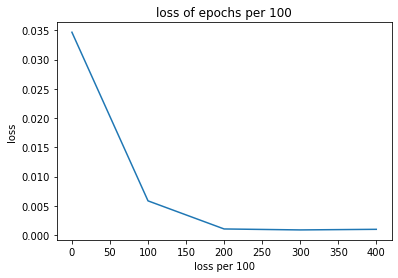

In [12]:
'''以损失函数作为标准进行训练并绘制图像,并返回预测值'''
#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = train(training_data_feature.to(torch.float32), training_data_pred.to(torch.float32), model, loss_MSE, optimizer, 500)


In [12]:
'''sMAPE精确度指标'''
def sMAPE(pred, y):
    n = pred.shape[0] * pred.shape[1]
    sum = abs(pred-y)/(abs(pred+y)/2)
    acc = torch.sum(sum)/n #将所有元素相加
    return acc*100

In [13]:
'''将归一化的数据恢复成原本的数据'''
def reverse_normalizationdata(data,max,min):
    range = max - min
    return torch.mul(data, range)+min

In [14]:
'''计算训练集预测值和真实值之间的sMAPE指标，和MAPE的用法一样，范围[0,+∞)，MAPE 为0%表示完美模型，MAPE 大于 100 %则表示劣质模型'''
train_max = np.max(train_data_rows)
train_min = np.min(train_data_rows)

train_max = torch.tensor(train_max)
train_min = torch.tensor(train_min)

y = reverse_normalizationdata(training_data_pred, train_max, train_min)
pred = reverse_normalizationdata(prediction, train_max, train_min)

#print(y[0])

acc = sMAPE(pred, y)

print("sMAPE指标："+str(acc.item())) #item可以只保留数字


sMAPE指标：25.73805048316833


In [15]:
'''对测试集和训练集预测后的值的sMAPE的计算'''
training_data_input = training_data[:,[range(56,735)]]  #要输入的训练集中后679个数据,用于预测test集
training_data_input = training_data_input.squeeze()

testing_data = torch.tensor(test_data_rows_nor) #将归一化的测试数据转化为tensor

prediction = model(training_data_input.to(torch.float32).to(device)) #用训练集后679个数据得到的预测值
#print(pred.shape)

#训练集数据最大值最小值
train_max = np.max(train_data_rows)
train_min = np.min(train_data_rows)
train_max = torch.tensor(train_max)
train_min = torch.tensor(train_min)

#测试集数据最大值最小值
test_max = np.max(test_data_rows)
test_min = np.min(test_data_rows)
test_max = torch.tensor(test_max)
test_min = torch.tensor(test_min)

pred = reverse_normalizationdata(prediction, train_max, train_min)   #pred代表训练集归一化后带入训练过的模型输出的预测值。并且用训练集的最大最小值进行反归一化
y = reverse_normalizationdata(testing_data, test_max, test_min)   #y代表真实的测试数据利用测试数据的最大最小值进行反归一化

acc = sMAPE(pred, y)

print("sMAPE指标："+str(acc.item())) #item可以只保留数字

sMAPE指标：28.074228184441026


In [16]:
'''利用未训练模型来计算sMAPE，来验证训练后的模型有效性'''
x = training_data[:,[range(56,735)]]  
x = x.squeeze()

model = NeuralNetwork().to(device)
prediction= model(x.to(torch.float32).to(device))

train_max = np.max(train_data_rows)
train_min = np.min(train_data_rows)
train_max = torch.tensor(train_max)
train_min = torch.tensor(train_min)
pred = reverse_normalizationdata(prediction, train_max, train_min)  

y = torch.tensor(test_data_rows)

acc = sMAPE(pred, y)
print("未经过训练模型计算出的sMAPE指标："+str(acc.item())) 

未经过训练模型计算出的sMAPE指标：1054.6111913020147
